In [1]:
import numpy as np
import cv2

In [2]:
cap= cv2.VideoCapture('WIN_20200117_16_17_44_Pro.mp4')

In [3]:
i=0
while(cap.isOpened()):
    ret,frame=cap.read()
    if ret==False:
        break
    cv2.imwrite('steer'+str(i)+'.jpg',frame)
    i+=1
    
cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

In [1]:
import tensorflow as tf
import scipy.misc
import cv2
from subprocess import call
import matplotlib.image as mpimg

In [2]:
import torch
import torchvision

model = torchvision.models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 4)

In [3]:
model.load_state_dict(torch.load('best_model_cones.pth',map_location=torch.device('cpu')))

In [4]:
import cv2
import numpy as np

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    #x = x.to(device)
    x = x[None, ...]
    return x

In [5]:
degrees=0

In [35]:
import torch.nn.functional as F
import time

# Simple PD controller (Kp - proportional term, Kd - derivative term)
Kp = 0.18
Kd = 0.05

frwd_value = 0.3                      # Default value to drive forward (0 = no action, 1 = full motor capacity)
rot_value_when_exploring = 0.3        # Default value to spin to the right when robot is in exploration mode (0 = no action, 1 = full motor capacity)
min_prob_free_to_drive_frwd = 0.25    # Min probability prob_free for robot to drive forward 
max_n_frames_stuck = 20               # Limit on the number of frames the robot is stuck for. Once this limit is reached, robot goes into exploration mode (makes large right turn)
frame_counter = 0                     # Frame counter 
n_frames_stuck = 0                    # Initialize counter of the number of successive frames the robot is stuck for
exploration = False                   # Initialize binary variable which determines if robot is in exploration mode (when True.) Used to mark the related frames with red background  
data_log = []                         # Initialize the array whcih will store a history of telemetry readings and robot actions (for analysis and tuning)
recent_detections = []                 # Initialize the array to store the last frame data

def update(change):
    global robot, frame_counter, n_frames_stuck, exploration
    x = change['new'] 
    x = preprocess(x)
    y = model(x)
    
    # apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
    y = F.softmax(y, dim=1)
    
    y = y.flatten()
   
    # extract probabilities of blocked, free, left and right
    prob_blocked = float(y[0])
    prob_free = float(y[1])
    prob_left = float(y[2])
    prob_right = float(y[3])
 
    # update list of recent detections
    while (len(recent_detections) >= 2):
        recent_detections.pop(0)
    recent_detections.append([prob_free,prob_left,prob_right,prob_blocked])
    
    # check if robot got stuck and update n_frames_stuck counter
    if prob_free < min_prob_free_to_drive_frwd:
        n_frames_stuck = n_frames_stuck + 1 
    else:
        n_frames_stuck = 0
        
    # calculate errors at times t (current) and t-1 (prev)    
    # error(t) and error(t-1): prob_left-prob_right   
    if len(recent_detections) == 2:
        current_probs = recent_detections[1]
        prev_probs = recent_detections[0]
    else:
        current_probs = [prob_free,prob_left,prob_right,prob_blocked]
        prev_probs = current_probs
                
    # error = prob_left-prob_right        
    current_error = current_probs[1] - current_probs[2]
    prev_error    = prev_probs[1] - prev_probs[2]

    # increment frame counter 
    frame_counter = frame_counter + 1
    
    # define functions which deterine (and return) robot actions
    def forward(value):
        #robot.forward(value)
        return ("FWRD",round(value,2))

    def left(value):
        #robot.left(value)
        return ("LEFT",round(value,2))

    def right(value):
        #robot.right(value)
        return ("RGHT",round(value,2))
    
    action = ""
  
    # estimate rotational value to turn left (if negative) or right (if positive)
    # 0 = no action, 1 = full motor capacity)
    rot_value = - Kp * current_error - Kd * (current_error - prev_error)
    
    # store propotional and differential controller components for frame-by-frame analysis
    p_component = - Kp * current_error
    d_component = - Kd * (current_error - prev_error)
    
    # initalize binary flag showinf if robot rotates 
    robot_rotates = False
    
    # action logic
    # moving forward if there is no obstacles
    if prob_free > min_prob_free_to_drive_frwd:
        action = forward(frwd_value)

    # turn left or right if robot is not blocked for a long time
    elif n_frames_stuck < max_n_frames_stuck:
        robot_rotates = True
        if rot_value < 0.0:
            action = left(rot_value)
        else:
            action = right(rot_value)

    # activate exploration mode - robot turns right by a large (45-90 degree) angle if it failed to move forward for [max_n_frames_stuck] recent frames
    else:
        exploration = True
        robot_rotates = True
        action = right(rot_value_when_exploring)
        time.sleep(0.5)
        n_frames_stuck = 0
    
    time.sleep(0.001)
    
    global degrees
    degrees=((action[1]+1)*180)-180
    print(action)
    
    # save frames - images with telemetry and robot actions data 
   # save_frames_with_telemetry(change['new'],current_probs,exploration,action,n_frames_stuck)
      
    # append frame's telemetry and robot action to the stored data 
    if not robot_rotates:
        rot_value = 0.
        p_component = 0.
        d_component = 0.
    if robot_rotates and exploration:
        rot_value = rot_value_when_exploring
        p_component = 0.
        d_component = 0.
    
    last_frame_data = [frame_counter, round(prob_free,3), round(prob_left,3), round(prob_right,3), round(prob_blocked,3),
                           action[0], action[1], round(rot_value,3), round(p_component,3), round(d_component,3), n_frames_stuck, exploration]
    data_log.append(last_frame_data)
    
    # reset variables
    exploration = False
    robot_rotates = False

In [36]:
import matplotlib.pyplot as plt
import time


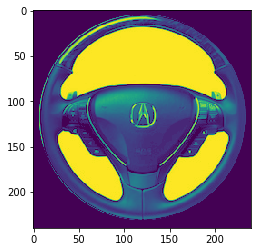

In [37]:
img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape
plt.imshow(img)


In [38]:
import os
def clear():
    os.system( 'cls' )
from IPython.display import clear_output
clear_output(wait=True)

In [ ]:
smoothed_angle = 0
i=0
while(cv2.waitKey(10) != ord('q')):
    #full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    full_img=mpimg.imread("steering_images/" + "steer" + str(2*i) + ".jpg")
    #full_img=mpimg.imread("dataset_cones/dataset_cones/left/" + "4f448c46-28f3-11ea-93fa-e2e803ec7935" + ".jpg")
    full_img=cv2.resize(full_img,(224,224))
    change={'new':full_img}
    update(change)
    #image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    #degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    print("Predicted steering angle: " + str(degrees) + " degrees")
    cv2.startWindowThread()
    cv2.namedWindow("frame")
    cv2.imshow("frame", cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    #smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-degrees,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    
   # cv2.namedWindow("steering Wheel")
    cv2.imshow('image',dst)
    cv2.waitKey(1)
    #plt.imshow(dst)
    #plt.show()
    #plt.close('dst')
    clear()
    clear_output(wait=True)
    i += 1

cv2.destroyAllWindows()

('RGHT', 0.16)
Predicted steering angle: 28.799999999999983 degrees
